In [ ]:
##only run this code on colab
! pip install neurodiffeq

#only run this on colab
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path
sys.path.append('drive/MyDrive/PINN/PINN_program/code/train')
print(sys.path)

In [7]:
from Fisher_models import *

import torch
import torch.nn as nn
import torch.nn.functional as F

from neurodiffeq import diff
from neurodiffeq.neurodiffeq import unsafe_diff as unsafe_diff
from neurodiffeq.conditions import IVP, DirichletBVP, DirichletBVP2D, BundleIVP, BundleDirichletBVP
from neurodiffeq.solvers import Solver1D, Solver2D, BundleSolver1D
from neurodiffeq.networks import FCNN, SinActv
from neurodiffeq.monitors import Monitor1D
from neurodiffeq.generators import Generator1D, Generator2D

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import time as time
from tqdm.auto import tqdm

import matplotlib.cm as cm
from matplotlib.colors import Normalize

from matplotlib.ticker import ScalarFormatter
import pickle

In [8]:
def plot_solutions16(solutions, title = None, savfig = None, figsize=(16, 3.5), subtitle_list = None, dpi=400):
  ##plot the 16 solutions
  fig, ax = plt.subplots(2, 8, figsize=figsize);

  for i in range(16):
    global_min = solutions[i].min()
    global_max = solutions[i].max()
    j = i // 8
    k = i % 8
    # Create color map
    cmap = plt.get_cmap('viridis');  # You can choose any colormap you prefer
    # Create colorbar
    im = ax[j][k].imshow(solutions[i][::-1, :], cmap=cmap, vmin=global_min, vmax=global_max);
    ax[j][k].axis('off')
    cbar = fig.colorbar(im, ax=ax[j][k], shrink=0.9, aspect=8)
    cbar.ax.tick_params(labelsize=6)
    if subtitle_list:
      ax[j][k].set_title(subtitle_list[i],
                         fontdict={'family': 'serif', 'color':  'darkred', 'weight': 'bold', 'size': 10})
  if title:
      plt.suptitle(title);
  plt.subplots_adjust(top=0.93)
  if savfig is not None:
    plt.savefig(savfig, dpi=dpi)

## Load all 8 models
with heads 2, 4, 6, 8, 10, 12, 14, 16

In [9]:
model_dict = {}
for k in range(2, 18, 2):
  model_dict[k] = Multihead_model(k=k, act = nn.functional.silu, bias=True)

In [10]:
path_dict = {
    2: "Fisher_2head_model_apr4_trig_1phase2.pickle",
    4: "Fisher_4head_model_apr4_trig_1phase2.pickle",
    6: "Fisher_6head_model_apr3_trig_1phase2.pickle",
    8: "Fisher_8head_model_mar30_trig_1phase2.pickle",
    10: "Fisher_10head_model_apr1_trig_1phase2.pickle",
    12: "Fisher_12head_model_apr1_trig_1phase2.pickle",
    14: "Fisher_14head_model_apr3_trig_1phase2.pickle",
    16: "Fisher_16head_model_dec25_trig_1phase.pickle"
}

In [11]:
for k in range(2, 18, 2):
  path = 'drive/MyDrive/PINN/PINN_program/code/train/experiment_log/' + path_dict[k]
  with open(path, 'rb') as f:
    model_dict[k] = pickle.load(f)

## Compute the H matrices for all models

In [12]:
##define the interior set used to do transfer learning on cpu
x, t, interior_tensor = generate_interior_tensor(I=60, require_grad = False)
##define the boundary set used to do transfer learing on cpu
x_boundary, t_boundary, boundary_tensor = generate_boundary_tensor(B=200, require_grad=False, method='equally-spaced')

In [13]:
##compute all the H matrices
bias=True; H_dicts = {}
for k in range(2, 18, 2):
  H_dicts[k] = compute_H_dict(model_dict[k], I=60, B=200, bias=bias)

Differentiating H w.r.t. x now...
Finished computing Hx.
Differentiating H w.r.t. t now...
Finished computing Ht
Differentiating H_b w.r.t. x now...
Finished computing Hx_b.
Differentiating H_b w.r.t. t now...
Finished computing Ht_b
Differentiating H w.r.t. x now...
Finished computing Hx.
Differentiating H w.r.t. t now...
Finished computing Ht
Differentiating H_b w.r.t. x now...
Finished computing Hx_b.
Differentiating H_b w.r.t. t now...
Finished computing Ht_b
Differentiating H w.r.t. x now...
Finished computing Hx.
Differentiating H w.r.t. t now...
Finished computing Ht
Differentiating H_b w.r.t. x now...
Finished computing Hx_b.
Differentiating H_b w.r.t. t now...
Finished computing Ht_b
Differentiating H w.r.t. x now...
Finished computing Hx.
Differentiating H w.r.t. t now...
Finished computing Ht
Differentiating H_b w.r.t. x now...
Finished computing Hx_b.
Differentiating H_b w.r.t. t now...
Finished computing Ht_b
Differentiating H w.r.t. x now...
Finished computing Hx.
Differe

In [14]:
#compute all the M and Minv matrices
#also compute all the H matrices evaluated on the x-girds
bias = True
M_dict = {}; Minv_dict = {}; H_grid_dict = {}
for key in H_dicts.keys():
  M_dict[key], Minv_dict[key] = compute_M(H_dicts[key])
  #compute the H matrix evaluated on the grid
  _, H  = model_dict[key](X_grid)
  ##detach the H
  H = H.detach().numpy() #shape (I, 3W)
  H = H.reshape(2*H.shape[0], -1) #transform all H into shape (3I, W)
  if bias: H = np.hstack((H, np.ones((H.shape[0], 1))))
  H_grid_dict[key] = H

### Manufactured Solution2
Now use the folloing manufactured solution:

$$
u(x, t) = Ax(x-\zeta)(x-1)sin(kt) + b
$$

With the corresponding forcing function:

$$
f(x, t) = kAx(x-\zeta)(x-1)cos(kt) - A(6x - 2(1+\zeta))sin(kt) - ru(1-u)
$$

In [15]:
def function_decorator4(A, zeta, k, b=0):
    def func(x, t):
        return A*x*(x-zeta)*(x-1)*torch.sin(k*t)+ b
    return func

def forcing_decorator4(A, zeta, k, r, b=0):
    func = function_decorator4(A, zeta, k, b=b)
    def force(x, t):
        dudt = k*A*x*(x-zeta)*(x-1)*torch.cos(k*t)
        dudxx = A*(6*x - 2*(1+zeta))*torch.sin(k*t)
        u = func(x, t)
        return dudt - dudxx - r*u*(1-u)
    return force

In [16]:
A = 0.3; k =2*np.pi + 1; r = 0.9; zeta = 0.4
exact_func = function_decorator4(A, zeta, k, b=0.5)
forcing = forcing_decorator4(A, zeta, k, r, b=0.5)
exact_values = exact_func(x,t).detach().numpy().reshape(60, -1)
forcing_values = forcing(x, t).detach().numpy().reshape(60, -1)

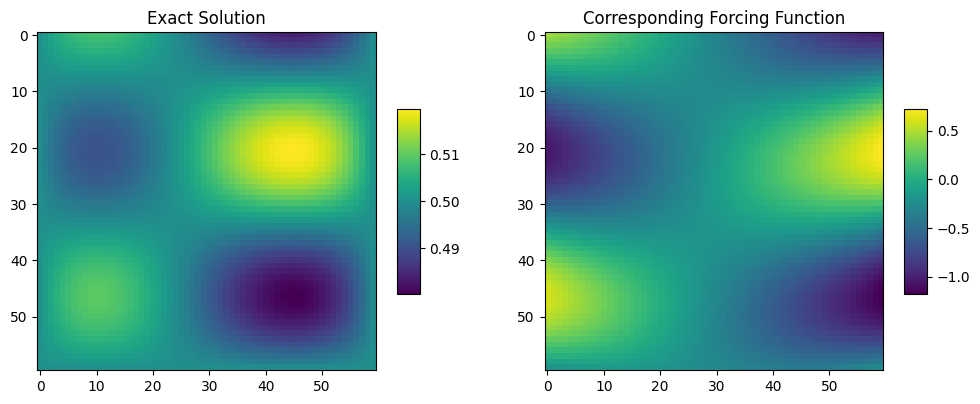

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6));
im0 = ax[0].imshow((exact_values.T)[::-1]);
im1 = ax[1].imshow((forcing_values.T)[::-1]);
cbar0 = fig.colorbar(im0, ax=ax[0], shrink=0.4, aspect=8);
cbar0.ax.tick_params(labelsize=10);
cbar1 = fig.colorbar(im1, ax=ax[1], shrink=0.4, aspect=8);
cbar1.ax.tick_params(labelsize=10);
ax[0].set_title("Exact Solution");
ax[1].set_title("Corresponding Forcing Function");

In [18]:
manu_list_list = []; perturb_list_list = []; fl_list_list = []; mse_list_list = []

for k in tqdm(H_dicts.keys()):
  H_dict = H_dicts[k]
  Minv = Minv_dict[k]
  H = H_grid_dict[k]
  model = model_dict[k]

  zeta_list = np.linspace(0.4, 0.6, 4)
  K_list = np.linspace(2*np.pi, 3*np.pi, 4)
  p = 40; b = 2; r = 0.8; A = 1;
  manufactured_list = []
  perturbation_list = []
  Fisher_loss_list = []
  mse_list = []

  for zeta in zeta_list:
      for k in K_list:
          ##compute the Perturbation solutions
          force = forcing_decorator4(A, zeta, k, r, b=b)
          f0_values = force(x, t).detach().numpy()
          result = Fisher_solver(H_dict, Minv, f0_values, b, r, H, p=p)
          perturbation_list.append(result['sol'])
          ##compute the truth solutions
          truth_func = function_decorator4(A, zeta, k, b=b)
          truth = truth_func(X_grid[:,0], X_grid[:, 1]).reshape(61, -1).detach().numpy()
          manufactured_list.append(truth)
          ##compute mse for each one
          mse_list.append(((truth - result['sol'])**2).mean())
          ##compute the Fisher loss
          Fisher_loss_list.append(Fisher_loss(model, result['W'], r, force, b0=b))

  manu_list_list.append(manufactured_list)
  perturb_list_list.append(perturbation_list)
  fl_list_list.append(Fisher_loss_list)
  mse_list_list.append(mse_list)

  0%|          | 0/8 [00:00<?, ?it/s]

In [19]:
for i, perturb in enumerate(perturb_list_list):
  plot_solutions16(perturb, 'Fisher solutions',
                  subtitle_list = ["Loss: " + str(round(l['total_loss'], 7)) for l in fl_list_list[i]]);

Output hidden; open in https://colab.research.google.com to view.

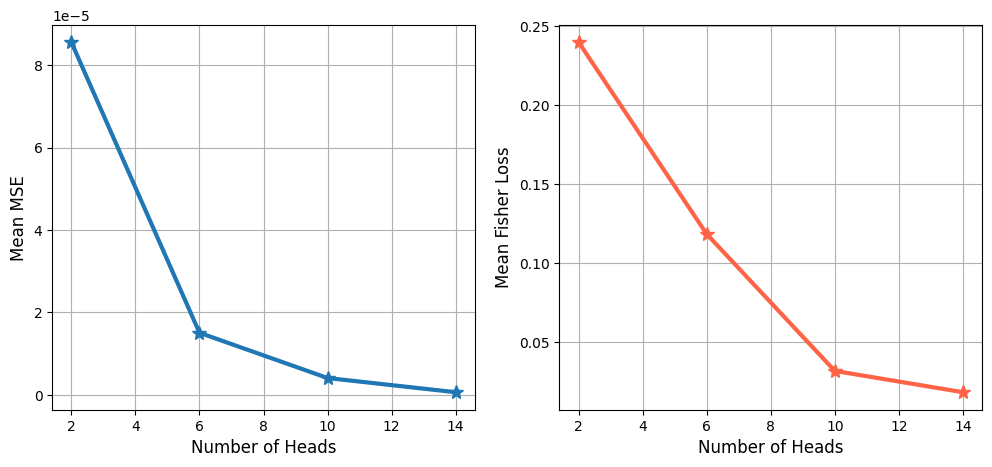

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
heads_range= range(2, 18, 2)
ax[0].plot([2, 6, 10, 14], np.array([np.mean(l) for l in mse_list_list])[[0, 2, 4, 6]], '*-', label="mean MSE",
           lw=3, markersize=10);

ax[1].plot([2, 6, 10, 14], np.array([np.mean([dic['total_loss'] for dic in l]) for l in fl_list_list])[[0, 2, 4, 6]],
           '*-', label='mean Fisher Loss', c='tomato', lw=3, markersize=10);
ax[0].grid();
ax[0].set_xlabel("Number of Heads", fontsize=12);
ax[0].set_ylabel("Mean MSE", fontsize=12);
ax[1].grid();
ax[1].set_xlabel("Number of Heads", fontsize=12);
ax[1].set_ylabel("Mean Fisher Loss", fontsize=12);

plt.savefig('Fisher_multiheads.png',dpi=500, bbox_inches='tight')